## Lab 10 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification
## 

In this lab, we will work through a common practice of Deep Learning Engineers - that is - take an existing model, that does something similar to what the engineer is interested doing, and fine-tune it for the specific task at-hand.

In [30]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, shutil, pathlib

In [31]:
tf.config.list_physical_devices("GPU")

[]

# **Introduction:**

In this leb our ***Goal*** is to develope 2 Neural Networks and apply VGG16 fine tuning (pre-trained on imagenet) on both models. After that, the results of both models should be ploted and analysied on validation data. Our data source is [here](https://www.kaggle.com/c/dogs-vs-cats/overview)

- Our 1 step is to Prepare the data and perform tasks like **Data Preprocessing** and **Data Exploration**.
- Modeling the Neural Networks using **VGG16** fine tuning
- **Evaluation** The evaluation of the model, to understand how well it performs.
- Write conclution

# **Data Exploration and Data Preprocessing**

In [33]:
original_dir = pathlib.Path("S:\Conestoga\Learning_Subject\Foundation_of_ML\Labs\Lab2\CSCN8010-LAB2\data/train/train")
new_base_dir_OP = pathlib.Path("S:\Conestoga\Learning_Subject\Foundation_of_ML\Labs\Lab2\CSCN8010-LAB2\data/train/train/new_base_dir_5k")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir_OP / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
        np.random.shuffle(fnames)       # Shuffle the data

make_subset("train", start_index=0, end_index=3000)
make_subset("validation", start_index=3000, end_index=4000)
make_subset("test", start_index=4000, end_index=5000)

Describe the sliceing of the data set

In [34]:
# check the number of images in each subset
print("Total training images of cat :", len(os.listdir(new_base_dir_OP / "train/cat")))
print("Total training images of dog :", len(os.listdir(new_base_dir_OP / "train/dog")))
print("Total validation images of cat :", len(os.listdir(new_base_dir_OP / "validation/cat")))
print("Total validation images of dog :", len(os.listdir(new_base_dir_OP / "validation/dog")))
print("Total test images of cat :", len(os.listdir(new_base_dir_OP / "test/cat")))
print("Total test images of dog :", len(os.listdir(new_base_dir_OP / "test/dog")))

Total training images of cat : 3000
Total training images of dog : 3000
Total validation images of cat : 1000
Total validation images of dog : 1000
Total test images of cat : 1000
Total test images of dog : 1000


Visulizing the first image in the Dog and Cat. 

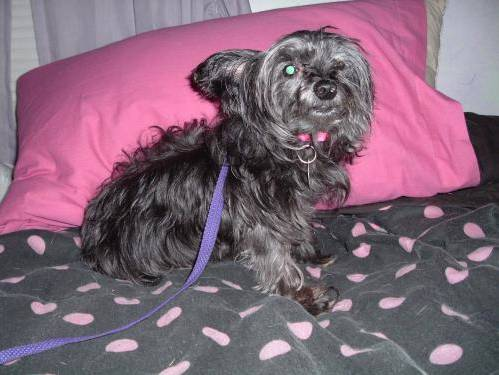

In [35]:
# looking at a dog's image using PIL - Python Imaging Library
import PIL.Image
dog = list(new_base_dir_OP.glob('train/dog/*'))
cat = list(new_base_dir_OP.glob('train/cat/*'))
PIL.Image.open(str(dog[0]))

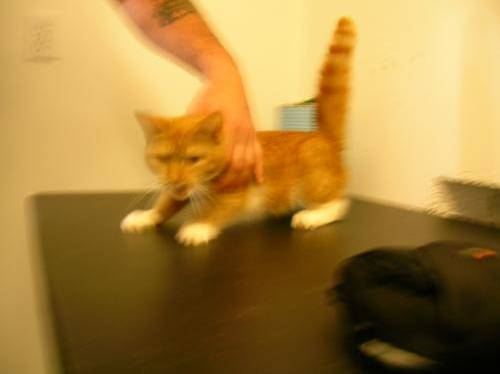

In [36]:
PIL.Image.open(str(cat[0]))

Describe why we are doing following step

In [37]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    "S:\Conestoga\Learning_Subject\Foundation_of_ML\Labs\Lab2\CSCN8010-LAB2\data/train/train/new_base_dir_5k/train",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    class_names=["cat", "dog"],
    shuffle=True,
    image_size=(240, 240),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    "S:\Conestoga\Learning_Subject\Foundation_of_ML\Labs\Lab2\CSCN8010-LAB2\data/train/train/new_base_dir_5k/validation",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    class_names=["cat", "dog"],
    shuffle=True,
    image_size=(240, 240),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    "S:\Conestoga\Learning_Subject\Foundation_of_ML\Labs\Lab2\CSCN8010-LAB2\data/train/train/new_base_dir_5k/test",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    class_names=["cat", "dog"],
    shuffle=True,
    image_size=(240, 240),
    batch_size=32)

Found 6000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Let's take a sneak peek at some training images.

In [38]:
for data_batch, labels_batch in train_dataset:
    print("Data batch shape:", data_batch.shape)
    print("Labels batch shape:", labels_batch.shape)
    break

Data batch shape: (32, 240, 240, 3)
Labels batch shape: (32,)


Above shape mevans that there is 32 images loaded into memory which is of size 240x240x3 (3 is RGB).

In [39]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0])>

Lets, see some images of Cat and Dog to undersstand how each image looks like after reshapeing it to **240x240** pixels.

In [40]:
# Visualize the train data for first 16 images
train_class_names = train_dataset.class_names   # Get the class names 

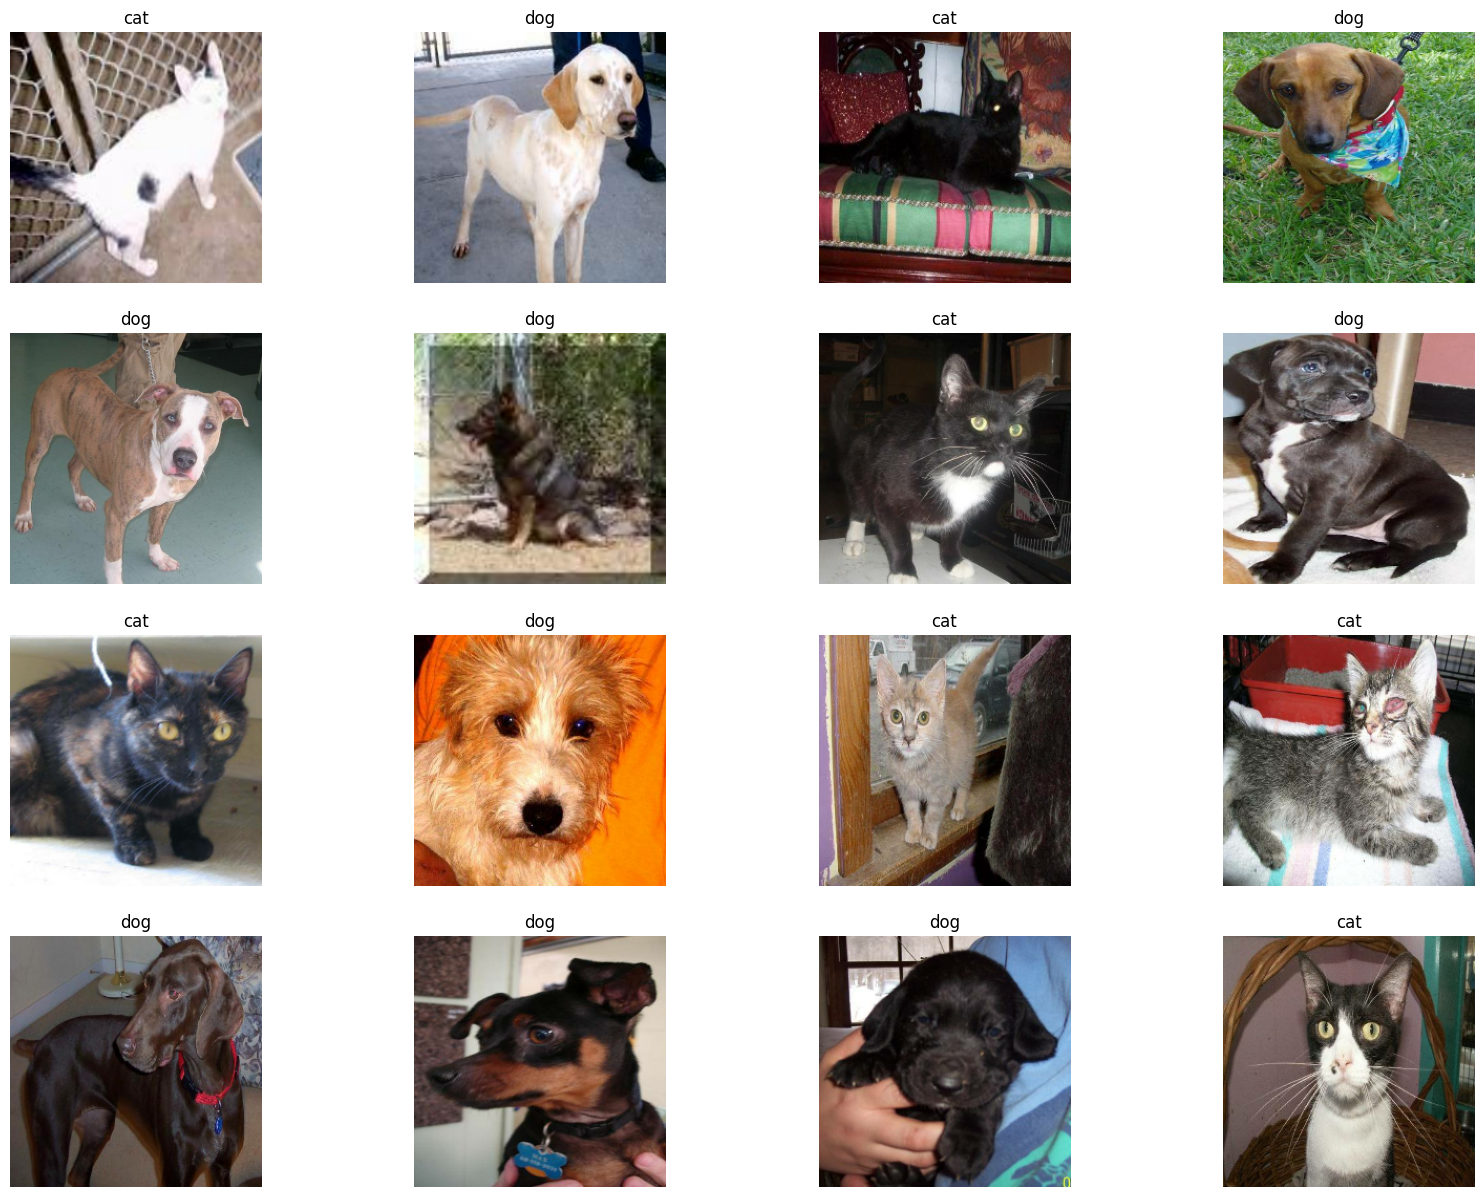

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_class_names[labels[i]])
    plt.axis("off")

Source for above is from tensorflow [doc](https://www.tensorflow.org/tutorials/load_data/images)

# **Modeling**

## Making 1 **VGG16** Model:

Making a simple CNN mode and then enhancing it self using VGG16 fine tuning.

- We utilize the pre-trained VGG16 model with weights from ImageNet and exclude the top classification layers.
- The layers of the VGG16 base model are frozen, preventing them from being updated during training.
- A new Sequential model is constructed on top of the frozen VGG16 base. This includes flattening the output and adding densely connected layers.

Leveraging pre-trained features from VGG16 can benefit the model in recognizing complex patterns.

In [42]:
VGG_base_model1 = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(240, 240, 3))

def get_features_and_labels(dataset):   # Extract features and labels from the dataset using the VGG16 model. 
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = VGG_base_model1.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 1s/step


In [43]:
print(train_features.shape)
print(train_labels.shape)
print(val_features.shape)
print(val_labels.shape)
print(test_features.shape)
print(test_labels.shape)

(6000, 7, 7, 512)
(6000,)
(2000, 7, 7, 512)
(2000,)
(2000, 7, 7, 512)
(2000,)


We have two sets of images (3000 images each) and a filter configuration (7x7 spatial matrix with 512 filters). 

Designing the NN model for image data using VGG16 approach. 

In [49]:
inputs_1M = keras.Input(shape=(7, 7, 512))
x = Flatten()(inputs_1M)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs_1 = Dense(1, activation="sigmoid")(x)
model_1_cnn = keras.Model(inputs=inputs_1M, outputs=outputs_1)

In [50]:
model_1_cnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
model_1_cnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 7, 7, 512)]       0         
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 6423041 (24.50 MB)
Trainable params: 6423041 (24.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
callbacks_cnn1 = [
    keras.callbacks.ModelCheckpoint(filepath="1model_best.keras", save_best_only=True,monitor="val_loss")
]
history_0 = model_1_cnn.fit(
    train_features, train_labels,
    epochs=40,      
    validation_data=(val_features, val_labels),
    callbacks=callbacks_cnn1)

Epoch 1/40
188/188 [==============================] - 10s 50ms/step - loss: 14.0022 - accuracy: 0.9557 - val_loss: 5.7823 - val_accuracy: 0.9755
Epoch 2/40
188/188 [==============================] - 9s 50ms/step - loss: 3.3148 - accuracy: 0.9868 - val_loss: 4.2381 - val_accuracy: 0.9825
Epoch 3/40
188/188 [==============================] - 9s 48ms/step - loss: 2.1760 - accuracy: 0.9893 - val_loss: 10.1741 - val_accuracy: 0.9705
Epoch 4/40
188/188 [==============================] - 9s 48ms/step - loss: 1.4343 - accuracy: 0.9922 - val_loss: 4.7636 - val_accuracy: 0.9805
Epoch 5/40
188/188 [==============================] - 9s 47ms/step - loss: 0.8398 - accuracy: 0.9948 - val_loss: 4.2591 - val_accuracy: 0.9840
Epoch 6/40
188/188 [==============================] - 9s 48ms/step - loss: 0.7446 - accuracy: 0.9967 - val_loss: 6.8644 - val_accuracy: 0.9805
Epoch 7/40
188/188 [==============================] - 9s 47ms/step - loss: 0.5218 - accuracy: 0.9970 - val_loss: 5.5247 - val_accuracy: 0.9

Ploting Validation vs Training Accuracy and Loss

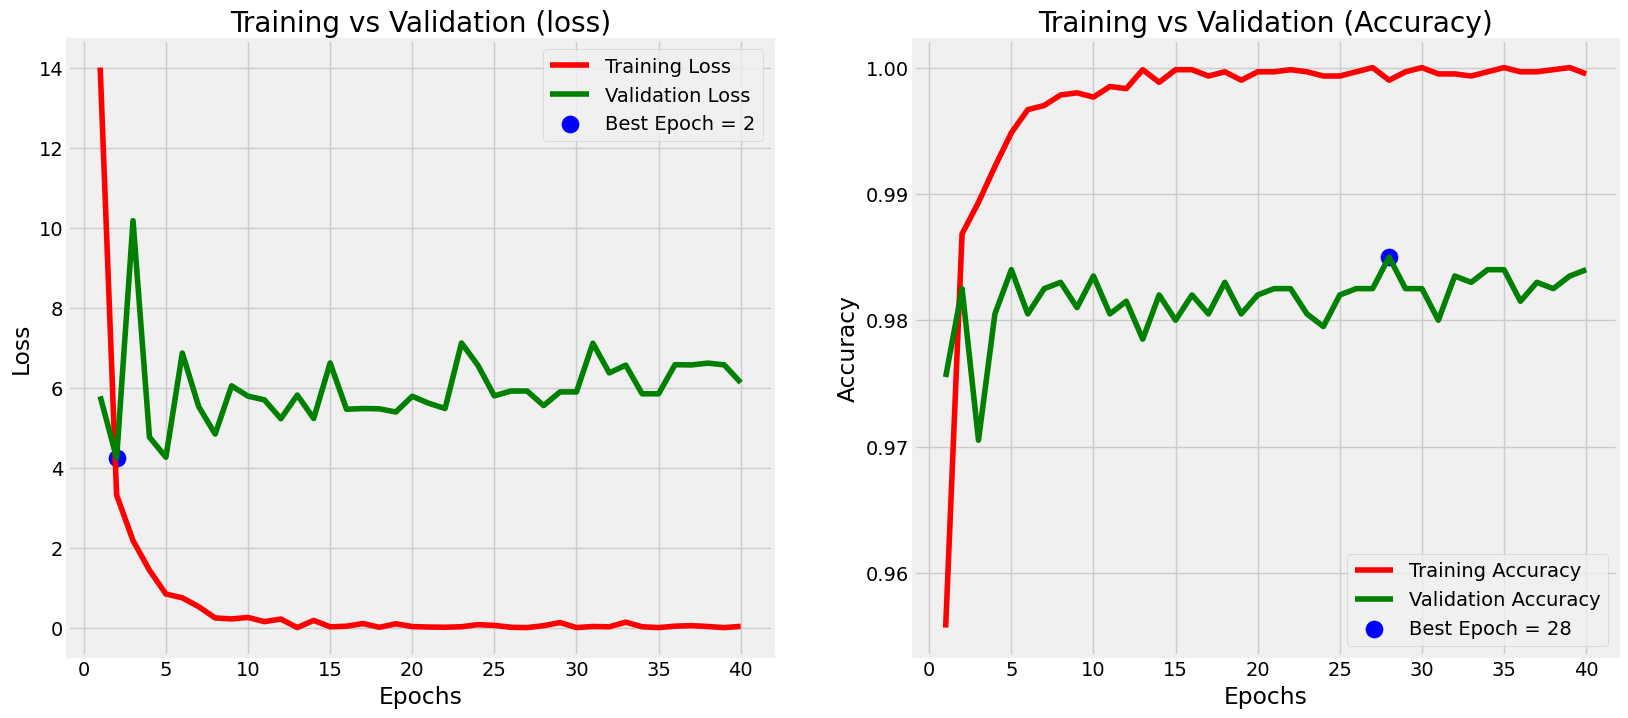

In [53]:
train_acc = history_0.history['accuracy']
train_loss = history_0.history['loss']

val_acc = history_0.history['val_accuracy']
val_loss = history_0.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r', label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r', label= 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue' , label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

### **Model 1** Results(Validation vs Training):
The image shows two graphs which depict the results of training ML model bsed on VGG16 fine tuning. More detailed info and analysis is given below.

* **Left Graph (Training vs. Validation Loss)**
    * The Red line represents the training loss.
    * The Green line represents the validation loss.
    * The "Best Epoch = 2" indicates that the validation loss was at its lowest at epoch 2.
    * Although, Training loss drops with each epoch validation loss starts to increase after best epoch (2) which means that model starts to overfit on training data.

* **Right Graph (Training vs. Validation Accuracy)**
    * The Red line represents the training accuracy.
    * The Green line represents the validation accuracy.
    * The caption "Best Epoch = 28" indicates that the validation accuracy was at its highest at epoch 28.
    * Same as Loss, the accuracy starts to increase and touches 100% but its on training data set so its not that accurate. Still validation accuracy was max at around 98% which is good.

To overcome this overfitting problem we can use method like *Data Augmentation*.

## Making 2 **CNN** Model:

Defining NN and fine tuning with VGG16 for model 2 architucture.

In [98]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define a simple CNN model
model_cnn_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(240, 240, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_cnn_2.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

checkpoint_cnn = ModelCheckpoint('2mode_best.h5', save_best_only=True, verbose=1)


In [99]:
base_model_2 = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

# Freeze pre-trained layers
for layer in base_model_2.layers:
    layer.trainable = False

# Add custom classification layers
model_vgg = Sequential([
    base_model_2,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [100]:
model_vgg.compile(optimizer="adam",
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

checkpoint_vgg = ModelCheckpoint('2mode_best.h5', save_best_only=True, verbose=1)

In [102]:
callbacks_cnn2 = [
    keras.callbacks.ModelCheckpoint(filepath="2mode_best.keras", save_best_only=True,monitor="val_loss")
]

num_train_samples = train_dataset.cardinality().numpy()
steps_per_epoch = num_train_samples // 32
num_val_samples = validation_dataset.cardinality().numpy()
validation_steps = num_val_samples // 32

history_vgg = model_vgg.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    callbacks=[callbacks_cnn2]
)

Epoch 1/20
5/5 [==============================] - 17s 3s/step - loss: 8.0869 - accuracy: 0.7437 - val_loss: 3.2189 - val_accuracy: 0.8125
Epoch 2/20
5/5 [==============================] - 15s 3s/step - loss: 1.3780 - accuracy: 0.8813 - val_loss: 0.4637 - val_accuracy: 0.9688
Epoch 3/20
5/5 [==============================] - 15s 3s/step - loss: 2.6323 - accuracy: 0.8875 - val_loss: 0.4574 - val_accuracy: 0.9062
Epoch 4/20
5/5 [==============================] - 13s 3s/step - loss: 1.2939 - accuracy: 0.9250 - val_loss: 2.0733 - val_accuracy: 0.9062
Epoch 5/20
5/5 [==============================] - 13s 3s/step - loss: 0.9711 - accuracy: 0.9312 - val_loss: 1.8119 - val_accuracy: 0.8750
Epoch 6/20
5/5 [==============================] - 13s 3s/step - loss: 1.0913 - accuracy: 0.9500 - val_loss: 2.8373 - val_accuracy: 0.8750
Epoch 7/20
5/5 [==============================] - 13s 3s/step - loss: 1.9312 - accuracy: 0.9312 - val_loss: 1.1595 - val_accuracy: 0.9062
Epoch 8/20
5/5 [==================

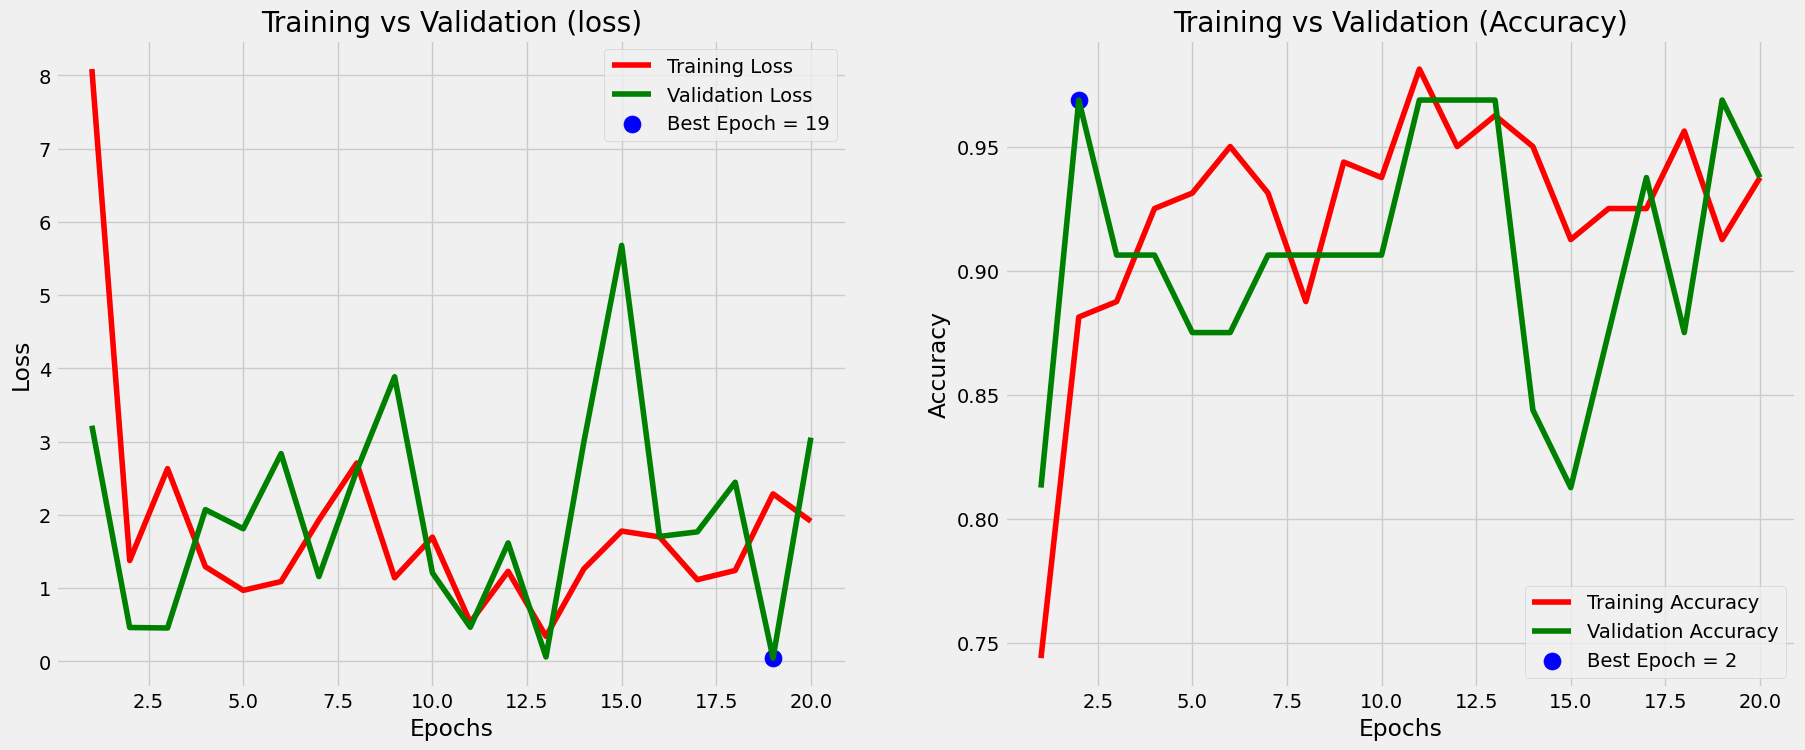

In [103]:
train_acc = history_vgg.history['accuracy']
train_loss = history_vgg.history['loss']

val_acc = history_vgg.history['val_accuracy']
val_loss = history_vgg.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r', label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r', label= 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue' , label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

* When it comes to Loss the lowest loss was at epoch 19 because validation loss was at its lowest. Accrdoing to graph, accuracy was at its top at epoch 2 with 96% accuracy on validation data. 

## Loading Saved Models

In [105]:
test_model_1 = keras.models.load_model("S:\Conestoga\Learning_Subject\Foundation_of_ML\Labs\Lab2\CSCN8010-LAB2/1model_best.keras")
test_model_2 = keras.models.load_model("S:\Conestoga\Learning_Subject\Foundation_of_ML\Labs\Lab2\CSCN8010-LAB2/2mode_best.keras")

In [111]:
CNN_model_1_test_predicted = test_model_1.predict(test_features)

53/63 [========================>.....] - ETA: 0s

63/63 [==============================] - 0s 4ms/step


In [114]:
accuracy_cnn = np.mean(CNN_model_1_test_predicted == test_labels)
print("Accuracy of CNN Model:", accuracy_cnn)

Accuracy of CNN Model: 0.49575


              precision    recall  f1-score   support

         0.0       0.99      0.83      0.90      1000
         1.0       0.85      0.99      0.92      1000

    accuracy                           0.91      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.92      0.91      0.91      2000



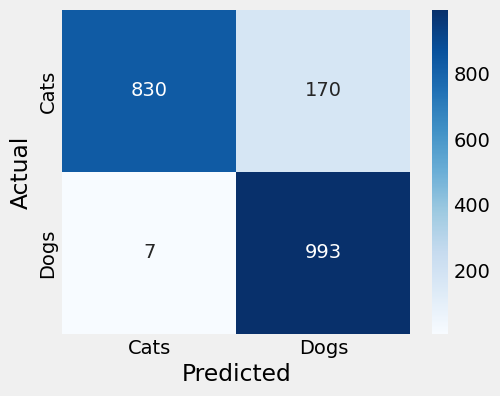

In [116]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

actual_labels = np.array([])
predicted_labels = np.array([])

for images, labels in validation_dataset:
        labels = labels.numpy().reshape(-1).astype(int)
        actual_labels = np.concatenate([actual_labels, labels])
        predictions = model_vgg.predict(images, verbose=False).reshape(-1)
        binary_predictions = (predictions > 0.5).astype(int)
        predicted_labels = np.concatenate([predicted_labels, binary_predictions])
        
print(classification_report(actual_labels, predicted_labels))

conf_mat = confusion_matrix(actual_labels, predicted_labels)
plt.figure(figsize=(5,4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Cats', 'Dogs'], yticklabels=['Cats', 'Dogs']) # 
plt.xlabel('Predicted'), plt.ylabel('Actual');

According to confusion matrix, most of the examples ware predicted accuractly only 170 of Cats images ware predicted wrongly.

### Conclusion:

Based on all the exersize done above I can say omdel 1 is most realyable compared to model 2.